# Evaluate the Harmony question matcher using the existing McElroy et al harmonisation tool as a gold standard

This is a validation of Harmony against the questionnaire harmonisation tool developed by McElroy et al in 2020.

You can read in detail about the validation report here:

https://harmonydata.org/measuring-the-performance-of-nlp-algorithms/

You can read an explanation of the technologies evaluated here:

https://harmonydata.org/how-does-harmony-work/

In [1]:
MODEL_NAME = "Model 7: Transformer with cosine similarity and preprocessing for opposite senses"

import sys
sys.path.append("../front_end")
from utils.question_matcher_transformer_huggingface_negation_efficient import QuestionMatcherTransformerHuggingFaceNegationEfficient
qm = QuestionMatcherTransformerHuggingFaceNegationEfficient()
match_function = lambda question_dfs : qm.match_questions(question_dfs, is_use_cosine_similarity=True)

In [2]:
from IPython.display import display, HTML
import bz2
import os
import pickle as pkl
import re
import sys
from nltk.corpus import stopwords
from langdetect import detect
import numpy as np
import operator 
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from utils.spacy_wrapper import get_spacy_model

pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)

In [3]:
INPUT_FILE = "../data/Final harmonised item tool EM.xlsx"


In [4]:
def normalise_question(original_text: str):
    """
    Checks if two questions have identical text.
    This is because they are by definition equivalent even if they are in different columns in the harmonisation tool by McElroy et al.
    """
    return re.sub(r'\W', '', original_text.lower())

In [5]:
validation_data = {}

for sheet_name in ("Childhood","Adulthood"):

    df = pd.read_excel(INPUT_FILE, sheet_name=sheet_name)

    if sheet_name == "Adulthood":
        labels_in_this_sheet = ["Adulthood"] * len(df)
        df = df[df.columns[4:]]
    else:
        labels_in_this_sheet = list(df["Developmental period"])
        df = df[df.columns[5:]]

    all_questions = []
    category_to_id = {}
    for idx in range(0, len(df)):
        questions_in_survey = []
        for column in df.columns:
            cell_content = df[column].iloc[idx]
            if type(cell_content) is str:
                for text in cell_content.split("/"):
                    text = re.sub(r'[^A-Za-z -,]', '', text.strip()).strip()
                    category = column.strip()
                    if category not in category_to_id:
                        category_to_id[category] = len(category_to_id)
                    category_id = category_to_id[category]
                    if len(text) > 2:
                        
                        questions_in_survey.append((text, category_id, normalise_question(text)))
        all_questions.append(questions_in_survey)
    
    validation_data[sheet_name] = all_questions

In [6]:
validation_data["GAD-7"] = [[], []]
for en, pt in zip("""Feeling nervous, anxious, or on edge
Not being able to stop or control worrying
Worrying too much about different things
Trouble relaxing
Being so restless that it is hard to sit still
Becoming easily annoyed or irritable
Feeling afraid, as if something awful might happen""".split("\n"),
"""Sentir-se nervoso/a, ansioso/a ou muito tenso/a
Não ser capaz de impedir ou de controlar as preocupações
Preocupar-se muito com diversas coisas
Dificuldade para relaxar
Ficar tão agitado/a que se torna difícil permanecer sentado/a
Ficar facilmente aborrecido/a ou irritado/a
Sentir medo como se algo horrível fosse acontecer""".split("\n")
                 ):
    validation_data["GAD-7"][0].append((en, en, normalise_question(en)))
    validation_data["GAD-7"][1].append((pt, en, normalise_question(pt)))

Validating on dataset Childhood
	Processing 47 instruments of average length 23 questions each


/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/harmony/lib/python3.10/site-packages/sentence_transformers/util.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  a = torch.tensor(a)


	Calculated 562315 match scores
	Generated 40708 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Tries to Stop Quarrels,"Is helpful if someone is hurt, upset or feeling ill",0.01,1
1,Tries to Stop Quarrels,"Shares readily with other children (treats, toys, pencils etc)",0.01,1
2,She is off and running as soon as she wakes up in the morning,I was very restless,0.03,1
3,Tries to Stop Quarrels,"Often volunteers to help others (parents, teachers, other children)",0.03,1
4,"Is upset by new situation, by things happening for the first time","A dare devil""",0.03,1
5,Stares into Space,I felt so tired I just sat around and did nothing,0.03,1
6,Child likes to sit and watch TV rather than play active games,"""A very hard worker",0.04,1
7,Tries to be Fair in Games,"Often volunteers to help others (parents, teachers, other children)",0.04,1
8,She is something of a loner,Gets on better with adults than with other children,0.04,1
9,"Is nervous or clingy in new situations, easily loses confidence","A dare devil""",0.05,1



FALSE POSITIVES OR WEAKEST REJECTIONS Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,"Overcompetitive with other children""","diffident about competing with other children""",0.93,0
1,Child bullies other children,Is bullied by other children,0.89,0
2,"usually gloomy and sad"" or ""Normal attitude to criticism and punishment","frequently disobedient"" or ""Normal attitude to criticism and punishment",0.87,0
3,Gets on With Other Children,Fights with other children,0.84,0
4,Other Children Dislike Child,Child bullies other children,0.84,0
5,Child is squirmy or fidgety,Child is fussy or overparticular,0.83,0
6,Bullies Other Children,Is bullied by other children,0.83,0
7,Has Stutter or Stammer,Has a stutter or stammer,0.83,0
8,Other Children Dislike Child,Bullies other children,0.81,0
9,sometimes restless in class,sometimes daydreams in class,0.79,0


Validating on dataset Adulthood
	Processing 28 instruments of average length 16 questions each
	Calculated 96017 match scores
	Generated 9580 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,I did everything wrong,What is your opinion of yourself compared to other people (rate selfdepreciation),0.01,1
1,I cried a lot,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.01,1
2,I did everything wrong,Are you selfconscious in public (rate simple ideas of reference),0.04,1
3,I laughed a lot,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.05,1
4,I felt miserable or unhappy,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.06,1
5,"Do you often feel on edge, or keyed up, or mentally tense or strained (rate nervous tension)",Found everything getting on top of you,0.07,1
6,I hated myself,Felt that you are playing a useful part in things,0.07,1
7,I hated myself,Are you selfconscious in public (rate simple ideas of reference),0.07,1
8,muscles feel tensed up (rate muscular tension),Found everything getting on top of you,0.07,1
9,I thought nobody really loved me,Been satisfied with the way you've carried out your task,0.08,1



FALSE POSITIVES OR WEAKEST REJECTIONS Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Do you often feel depressed,Do you often feel tired most of the time,0.81,0
1,Do you suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.77,0
2,Do you often feel depressed,Do you feel tired most of the time,0.77,0
3,Do you often feel tired most of the time,Do you often feel miserable or depressed,0.77,0
4,Are you frightened of going out alone or of meeting people,Are you scared to be alone when there are not friends near you,0.77,0
5,Have you been a very nervous person,Have you ever had a nervous breakdown,0.77,0
6,Felt that life is entirely hopeless,Felt that life isn't worth living,0.76,0
7,Do you often suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.75,0
8,Do you often feel tired most of the time,Do you often have backache,0.74,0
9,Been feeling nervous and strungup all the time,Been feeling run down and out of sorts,0.73,0


Validating on dataset GAD-7
Found GAD-7 Portuguese
	Processing 2 instruments of average length 7 questions each
	Calculated 49 match scores
	Generated 49 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES GAD-7



,Instrument 1,Instrument 2,Score from model,Ground truth
0,"Feeling nervous, anxious, or on edge","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.80,1
1,Being so restless that it is hard to sit still,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.81,1
2,Becoming easily annoyed or irritable,Ficar facilmente aborrecido/a ou irritado/a,0.88,1
3,Trouble relaxing,Dificuldade para relaxar,0.91,1
4,Not being able to stop or control worrying,Não ser capaz de impedir ou de controlar as preocupações,0.91,1
5,"Feeling afraid, as if something awful might happen",Sentir medo como se algo horrível fosse acontecer,0.92,1
6,Worrying too much about different things,Preocupar-se muito com diversas coisas,0.93,1



FALSE POSITIVES OR WEAKEST REJECTIONS GAD-7



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Being so restless that it is hard to sit still,Dificuldade para relaxar,0.60,0
1,Becoming easily annoyed or irritable,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.54,0
2,Becoming easily annoyed or irritable,Dificuldade para relaxar,0.54,0
3,Becoming easily annoyed or irritable,"Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.54,0
4,"Feeling nervous, anxious, or on edge",Ficar facilmente aborrecido/a ou irritado/a,0.53,0
5,Not being able to stop or control worrying,Ficar facilmente aborrecido/a ou irritado/a,0.49,0
6,"Feeling afraid, as if something awful might happen","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.49,0
7,Becoming easily annoyed or irritable,Não ser capaz de impedir ou de controlar as preocupações,0.48,0
8,Trouble relaxing,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.46,0
9,"Feeling nervous, anxious, or on edge",Não ser capaz de impedir ou de controlar as preocupações,0.45,0


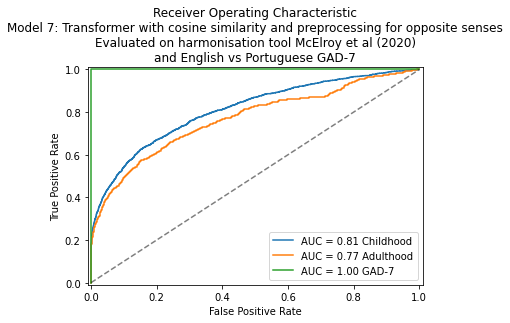

In [7]:
for dataset, dataset_data in validation_data.items():
    print (f"Validating on dataset {dataset}")
    question_dfs = []
    for questionnaire in dataset_data:
        df = pd.DataFrame({"question": [q for q, c, n in questionnaire]})
        df.attrs['language'] = "en"
        if dataset == "GAD-7" and "Sentir" in questionnaire[0][0]:
            df.attrs['language'] = "pt"
            print ("Found GAD-7 Portuguese")
        question_dfs.append(df)
    
    print (f"\tProcessing {len(question_dfs)} instruments of average length {int(np.round(np.mean([len(d) for d in question_dfs])))} questions each")
    matches = match_function(question_dfs)
    
    print (f"\tCalculated {len(matches)} match scores")
    
    pairs_already_seen = set()
    gold_standard = {}
    for i in range(len(dataset_data)):
        for j in range(i + 1, len(dataset_data)):
            for ii in range(len(dataset_data[i])):
                for jj in range(len(dataset_data[j])):
                    tup = tuple(sorted([dataset_data[i][ii][2], dataset_data[j][jj][2]]))
                    if tup not in pairs_already_seen:
                        gold_standard[(i, ii, j, jj)] = int(
                            (dataset_data[i][ii][1] == dataset_data[j][jj][1])
                            or 
                            (dataset_data[i][ii][2] == dataset_data[j][jj][2])
                        )
                    pairs_already_seen.add(tup)
    
    print (f"\tGenerated {len(gold_standard)} gold-standard values to compare them to")
    
    print ("\tCalculating ROC curve")
    
    y_pred = []
    y_test = []
    for m, g in gold_standard.items():
        y_pred.append(abs(matches.get(m, 0)))
        y_test.append(g)

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = f'AUC = {roc_auc:0.2f} {dataset}')
    
    print (f"\nFALSE NEGATIVES OR WEAKEST MATCHES {dataset}\n")

    all_positives = [m for m in gold_standard if gold_standard[m] == 1 ]
    estimated_values_for_gt_1 = dict([(m,abs(matches[m])) for m in all_positives ])

    ctr = 0    
    examples = []
    for match_tuple, score_from_model in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1)):
        examples.append((question_dfs[match_tuple[0]].question.iloc[match_tuple[1]], question_dfs[match_tuple[2]].question.iloc[match_tuple[3]], np.round(score_from_model, 2)))

        ctr += 1
        if ctr > 10:
            break
    df_examples = pd.DataFrame({"Instrument 1":[e[0] for e in examples],"Instrument 2":[e[1] for e in examples],"Score from model":[e[2] for e in examples]})
    df_examples["Ground truth"] = 1
    display(df_examples)
    

    print (f"\nFALSE POSITIVES OR WEAKEST REJECTIONS {dataset}\n")

    all_negatives = [m for m in gold_standard if gold_standard[m] == 0 ]
    estimated_values_for_gt_1 = dict([(m,abs(matches[m])) for m in all_negatives ])

    ctr = 0
    examples = []
    for match_tuple, score_from_model in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1), reverse=True):
        examples.append((question_dfs[match_tuple[0]].question.iloc[match_tuple[1]], question_dfs[match_tuple[2]].question.iloc[match_tuple[3]], np.round(score_from_model, 2)))

        ctr += 1
        if ctr > 10:
            break
    df_examples = pd.DataFrame({"Instrument 1":[e[0] for e in examples],"Instrument 2":[e[1] for e in examples],"Score from model":[e[2] for e in examples]})
    df_examples["Ground truth"] = 0
    display(df_examples)

            
plt.title(f'Receiver Operating Characteristic\n{MODEL_NAME}\nEvaluated on harmonisation tool McElroy et al (2020)\nand English vs Portuguese GAD-7')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='black', alpha=0.5)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()